In [1]:
from os import listdir,mkdir
from os.path import join,exists
from time import time
import json
import datetime


import tensorflow as tf
import numpy as np


import skimage
from skimage.transform import resize
from scipy.misc import imread
from PIL import Image

from collections import Counter
from time import time

from utils import load_dataset, load_vocab, get_batch

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics.pairwise import euclidean_distances
def load_image(p):
    img = Image.open(p)
    if img.mode is not 'RGB':
        img = img.convert('RGB')
    treated_img = img.resize((448,448))
    treated_img = np.array(treated_img) / 255.0
    assert (0 <= treated_img).all() and (treated_img <= 1.0).all()
    return treated_img,img

def intersect(r1,r2):
    left = max(r1[0], r2[0])
    top = max(r1[1], r2[1])
    right = min(r1[0]+r1[2], r2[0]+r2[2])
    bottom = min(r1[1]+r1[3], r2[1]+r2[3])
    return left, top, max(0,right-left), max(0,bottom-top)

def getIoU(candidates):
    # Computes an IoU matrix from a list of rectangles
    IoU = np.zeros((len(candidates), len(candidates)))
    for i in range(len(candidates)):
        r1 = candidates[i]
        r1_area = r1[2]*r1[3]
        for j in range(i+1,len(candidates)):
            r2 = candidates[j]
            r2_area = r2[2]*r2[3]
            inter =  intersect(r1, r2)
            inter = inter[2]*inter[3]
            iou = inter / (r1_area+r2_area-inter)
            IoU[i,j] = iou
            IoU[j,i] = iou
    return IoU

def getDistances(candidates):
    # Computes a distance matrix from a list of candidates
    centers = [(c[0]+c[2]/2,c[1]+c[3]/2) for c in candidates]
    return euclidean_distances(centers)

In [2]:
image_paths = {}
root_path = "/srv/data/datasets/mscoco/images/"

for split in 'train val'.split():
    image_ids_path = "datasets/vqa/"+split+"/img_ids.txt"
    image_ids = set([int(x.strip()) for x in open(image_ids_path).readlines()])
    print(split,len(image_ids))
    for x in image_ids:
        name = 'COCO_'+split+'2014_'+format(x, '012')+'.jpg'
        path = join(root_path,split+"2014",name)
        image_paths[str(x)] = path

train 82783
val 40504


In [3]:
def load_dataset(idxs_path,mc=False):
    dataset = []
    for l in open(idxs_path, 'r',encoding='latin1'):
        if mc:
            l = [[int(i) for i in ans.strip().split()] for ans in l.strip().split('|')]
        else:
            l = [int(i) for i in l.strip().split()]
        dataset.append(l)
    return dataset

class Dataset(object):
    def __init__(self, i_path, q_path, mc_path, a_path, bb_path, n_max=np.Inf):
        self.i_path = i_path
        self.q_path = q_path
        self.a_path = a_path
        self.mc_path = mc_path
        self.bb_path = bb_path
        print('Parse questions file')
        q_data = load_dataset(self.q_path)
        self.max_q = len(max(q_data, key=lambda x:len(x)))
        print('Parse answers file')
        a_data = load_dataset(self.a_path)
        print('Parse MC file')
        mc_data = load_dataset(self.mc_path,mc=True)
        self.max_mc = 0
        for mc in mc_data:
            for x in mc:
                self.max_mc = max(self.max_mc,len(x))
        print('Parse BB file')
        self.bboxes = {}
        for l in open(self.bb_path):
            l = json.loads(l)
            self.bboxes.update(l)
        print("Construct data array")
        self.data = []
        self.max_bb = -np.Inf
        for i_id,q,mc,a in zip(open(i_path),q_data,mc_data,a_data):
            i_id = i_id.strip()
            if i_id not in self.bboxes:
                continue
            bb = self.bboxes[i_id]
            self.max_bb = max(self.max_bb,len(bb))
            datum = (i_id,bb,q,mc,a)
            self.data.append(datum)
        self.data = np.array(self.data, dtype=object)
        del q_data,a_data
        self.N = len(self.data)
        self.indexes = np.arange(self.N)
    
    def __iter__(self):
        return self
    
    def batch_gen(self,batch_size=64,shuffle=True):
        if shuffle:
            np.random.shuffle(self.indexes)
        n_batches = self.N // batch_size
        for batch_id in range(n_batches):
            begin = batch_id*batch_size
            end = min((batch_id+1)*batch_size, self.N)
            B = self.data[self.indexes[begin:end]]
            yield B


print("Loading train set")
train_set = Dataset("datasets/vqa/train/img_ids.txt",
                   "datasets/vqa/train/questions.idxs", 
                   "datasets/vqa/train/mcs.idxs", 
                   "datasets/vqa/train/answers.idxs",
                   "datasets/vqa/train/bounding_boxes.json")
print("Loading val set")
val = Dataset("datasets/vqa/val/img_ids.txt",
                   "datasets/vqa/val/questions.idxs", 
                   "datasets/vqa/val/mcs.idxs", 
                   "datasets/vqa/val/answers.idxs",
                   "datasets/vqa/val/bounding_boxes.json")
max_bb = train_set.max_bb
max_q = train_set.max_q
max_mc = train_set.max_mc

Loading train set
Parse questions file
Parse answers file
Parse MC file
Parse BB file
Construct data array
Loading val set
Parse questions file
Parse answers file
Parse MC file
Parse BB file
Construct data array


In [4]:
q_i2w, q_w2i = load_vocab('datasets/vqa/train/questions.vocab')
a_i2w, a_w2i = load_vocab('datasets/vqa/train/answers.vocab')
Nq = len(q_i2w)
Na = len(a_i2w)
max_bb = 60

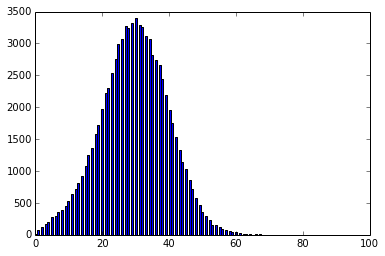

In [5]:
plt.figure()
plt.hist([len(v) for v in train_set.bboxes.values()],bins='auto')
plt.show()

In [6]:
def indexes_tensor(axis,batch_size):
    indexes = tf.expand_dims(tf.range(0,28,1),axis)
    mat_multiples = [28]
    mat_multiples.insert(1-axis,1)
    matrix = tf.tile(indexes, mat_multiples)
    tensor = tf.tile(tf.expand_dims(matrix,0),[batch_size,1,1])
    return tensor

In [7]:
batch_size = 16
di = 200
dq = 200
dh = 200
datt = 200
tf.reset_default_graph()

with open("tensorflow-vgg16/vgg16.tfmodel", mode='rb') as f:
    fileContent = f.read()

Pl = {}
    ## Variables
        # VGG16
graph_def = tf.GraphDef()
graph_def.ParseFromString(fileContent)
        # Image transformationt
with tf.variable_scope('image'):
    tf.get_variable('W', shape=[512, di],
                    initializer=tf.contrib.layers.xavier_initializer())
    tf.get_variable(name='b',
                    initializer=tf.zeros([di]))
with tf.variable_scope('attention'):
    tf.get_variable('Wimg',shape=[di,datt],
                    initializer=tf.contrib.layers.xavier_initializer())
    tf.get_variable('Wstate',shape=[dh,datt],
                    initializer=tf.contrib.layers.xavier_initializer())

        # Question embedding
with tf.variable_scope('question'):
    tf.get_variable('W',
                    initializer=tf.random_uniform([Nq, dq], -0.1, 0.1))
with tf.variable_scope('multiple_choice'):
    tf.get_variable('W',
                    initializer=tf.random_uniform([Na, dh], -0.1, 0.1))
    
        # RNN
# rnn = tf.nn.rnn_cell.BasicRNNCell(dh)
rnn = tf.nn.rnn_cell.GRUCell(dh)
## Placeholders
Pl['images'] = tf.placeholder("float", 
                              [batch_size, 448, 448, 3],
                              name="images") #batch x width x height x channels
Pl['boxes'] = tf.placeholder("int32",
                             [batch_size,max_bb,4],
                             name="boxes") #batch x boxes x coords
Pl['boxes_mask'] = tf.placeholder('float32', 
                                  [batch_size,max_bb],
                                  name="boxes_mask")
Pl['questions'] = tf.placeholder(tf.int32, 
                                 [batch_size, max_q],
                                 name="question")
Pl['question_mask'] = tf.placeholder(tf.int32,
                                     [max_q, None],
                                     name="question_mask")
Pl['mc'] = tf.placeholder(tf.int32,
                          [batch_size, 18,None], 
                          name="mc")
Pl['answers'] = tf.placeholder(tf.float32, 
                               [batch_size,18], 
                               name="answers")

def compute_attention(V,state):
    with tf.variable_scope('attention',reuse=True):
        Wimg = tf.get_variable('Wimg')
        Wstate = tf.get_variable('Wstate')
        Vatt = tf.transpose(tf.tanh(tf.reshape(tf.matmul(tf.reshape(V, 
                                                       (batch_size*max_bb,di)),
                                             Wimg),
                                   (max_bb,batch_size,datt))),(1,0,2))
        Vatt = tf.nn.l2_normalize(Vatt,-1)
        Hatt = tf.expand_dims(tf.matmul(state,Wstate),1)
        Hatt = tf.nn.l2_normalize(Hatt,-1)
        att = tf.batch_matmul(Vatt,Hatt,adj_y=True)
        patt0 = tf.nn.softmax(att[:,:,0])
        with tf.device('/cpu:0'):
            patt1 = tf.mul(patt0,Pl['boxes_mask'])
        patt = patt1 / tf.expand_dims(tf.reduce_sum(patt1,reduction_indices=1),1)
        Vpond = tf.mul(V,tf.expand_dims(tf.transpose(patt),-1))
        Vt = tf.reduce_sum(Vpond,reduction_indices=0)
        return Vt,patt0,patt1,patt

tf.import_graph_def(graph_def, input_map={"images": Pl['images']})

graph = tf.get_default_graph()
out_tensor = graph.get_tensor_by_name("import/conv5_3/Relu:0")
boxes_o = tf.cast(Pl['boxes']/16,tf.int32)

Rs = []
X,Y = indexes_tensor(0,batch_size),indexes_tensor(1,batch_size)
for j in range(max_bb):
    bxs = boxes_o[:,j,:]
    bxs_expanded = tf.expand_dims(tf.expand_dims(bxs,-1),
                                  -1)
    maskX = tf.logical_and(tf.greater_equal(X,bxs_expanded[:,0,:,:]), 
                           tf.less_equal(X,bxs_expanded[:,0,:,:]+bxs_expanded[:,2,:,:]))
    maskY = tf.logical_and(tf.greater_equal(Y,bxs_expanded[:,1,:,:]),
                           tf.less_equal(Y,bxs_expanded[:,1,:,:]+bxs_expanded[:,3,:,:]))
    mask = tf.cast(tf.logical_and(maskX,maskY), tf.float32)
    mask_expanded = tf.expand_dims(mask,-1)
    R = tf.mul(out_tensor,mask_expanded)
    Rs.append(tf.reduce_max(R,reduction_indices=(1,2)))
    # Must be batch_size x 512
Rs = tf.pack(Rs)
with tf.variable_scope('image',reuse=True):
    W = tf.get_variable('W')
    b = tf.get_variable('b')
    V = tf.tanh(tf.reshape(tf.matmul(tf.reshape(Rs, 
                                                (batch_size*max_bb,512)),
                                     W) + b,
                           (max_bb,batch_size,di)))
state = rnn.zero_state(batch_size, tf.float32)
states = []
q_out = []
with tf.variable_scope('question',reuse=True):
    W = tf.get_variable('W')
for j in range(max_q):
    question_emb = tf.nn.embedding_lookup(W, Pl['questions'][:,j])
    if j>0:
        tf.get_variable_scope().reuse_variables()
    Vt,_,_,_ = compute_attention(V,state)
    output,state = rnn(tf.concat(1,[question_emb,Vt]), state)
    states.append(state)
    q_out.append(output)
q_out = tf.pack(q_out)
q_out = tf.reduce_sum(tf.mul(q_out, 
                             tf.to_float(tf.expand_dims(Pl['question_mask'],-1))),0)
q_out = tf.nn.l2_normalize(q_out,-1)

mc_mask = tf.to_float(tf.not_equal(Pl['mc'],a_w2i['</s>']))
norm_mask = tf.expand_dims(tf.reduce_sum(mc_mask,reduction_indices=2),-1)
with tf.variable_scope('multiple_choice'):
    W = tf.get_variable('W')
    mc_emb = tf.nn.embedding_lookup(W, Pl['mc'])
    masked_mc_out = tf.mul(tf.expand_dims(mc_mask,-1),mc_emb)
    mc_out = tf.reduce_sum(masked_mc_out,reduction_indices=2)/norm_mask
    mc_out = tf.nn.l2_normalize(mc_out,-1)
        
out_scores = tf.batch_matmul(mc_out,tf.expand_dims(q_out,1),adj_y=True)[:,:,0]
out_probas = tf.nn.softmax(out_scores)

normalized_ans = Pl['answers'] / tf.expand_dims(tf.reduce_sum(Pl['answers'],reduction_indices=1),-1)
cross_entropy = normalized_ans*tf.log(out_probas) + (1.-normalized_ans)*tf.log(1.-out_probas)
cost = -tf.reduce_sum(cross_entropy)/batch_size

optimizer = tf.train.AdamOptimizer()
# optimizer = tf.train.GradientDescentOptimizer(0.01)
gvs = optimizer.compute_gradients(cost)
# with tf.device('/cpu:0'):
cost_s = tf.scalar_summary('train loss', cost, name='train_loss')
capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad,var in gvs]
train_op = optimizer.apply_gradients(capped_gvs)
    

In [8]:
model_name = "model1"
model_rootpath = "/home/hbenyounes/vqa/results/vqa/"
model_path = join(model_rootpath,model_name)
if not exists(model_path):
    mkdir(model_path)

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.6)

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True,
                                        gpu_options=gpu_options))

writer = tf.train.SummaryWriter(join(model_path,'tf_log'), sess.graph)
init = tf.initialize_all_variables()
sess.run(init)

In [9]:
def create_feeddict(batch):
    boxes = np.zeros((batch_size,max_bb,4),dtype='int')
    boxes_mask = np.zeros((batch_size,max_bb), dtype="float")
    question_mask = np.zeros((max_q,batch_size),dtype="float")
    questions = np.zeros((batch_size,max_q), dtype='int')
    answers = np.zeros((batch_size,18),dtype="float")
    # multiple_choice = np.zeros((batch_size,18,max_mc),dtype='int')
    multiple_choice = []
    images = np.zeros((batch_size,448,448,3))
    mc_len = 0
    img_time = 0
    bb_time = 0
    question_time = 0
    answer_time = 0
    for batch_id,(i_id,bb,q,mc,a) in enumerate(batch):
        # b = (i_id,bb,q,mc,a)
        p = image_paths[i_id]
        tic = time()
        im_l,im = load_image(p)
        img_time += time() - tic
        images[batch_id] = im_l
        tic = time()
        bb = bb[:max_bb]
        box = np.pad(bb, [(0,max_bb-len(bb)),
                            (0,0)], 
                     'constant')
        boxes_mask[batch_id,:len(bb)] = 1
        box[:,[0,2]] = box[:,[0,2]]*im_l.shape[1]/im.size[1]
        box[:,[1,3]] = box[:,[1,3]]*im_l.shape[0]/im.size[0]
        boxes[batch_id] = box
        bb_time += time() - tic
        tic = time()
        questions[batch_id] = np.pad(q,(0,max_q-len(q)),'constant')
        question_mask[len(q),batch_id] = 1
        question_time += time()-tic
    #     multiple_choice[batch_id] = np.array([np.pad(m,(0,max_mc-len(m)),'constant') for m in mc])
        multiple_choice.append(mc)
        tic = time()
        for i,x in enumerate(mc):
            answers[batch_id,i] = 1*(a==x)
        mc_len = max(mc_len,len(max([x for x in mc], key=len)))
        answer_time += time() - tic
    tic = time()
    multiple_choice = np.array([[np.pad(m,(0,mc_len+1-len(m)),
                                        'constant',
                                        constant_values=a_w2i['</s>']) for m in mc] for mc in multiple_choice])
    mc_time = time() - tic
#     print(img_time,bb_time,question_time,answer_time,mc_time)
    feed_dict = {Pl['images']: images,
                 Pl['boxes']:boxes, 
                 Pl['boxes_mask']:boxes_mask,
                 Pl['question_mask']:question_mask,
                 Pl['questions']:questions,
                 Pl['mc']:multiple_choice, 
                 Pl['answers']:answers}
    return feed_dict

In [10]:
def test():
    accuracy = []
    val_gen = val.batch_gen(batch_size)
    for idx,batch in enumerate(val_gen):
        if not idx%100:
            print("\tTest: %d/%d" % (idx,val.N))
        feed_dict = create_feeddict(batch)
        y_pred = sess.run(out_probas,feed_dict=feed_dict).argmax(axis=1)
        accuracy.append(feed_dict[Pl['answers']][np.arange(batch_size),y_pred])
    return np.mean(accuracy)

In [11]:
break_all = False
n_epochs = 100
n_batches = train_set.N//batch_size + 1
loss_value = 0
total_time = 0.
output_file = open(join(model_path,"output.txt"),'w')
for epoch in range(1,1+n_epochs):
    train_gen = train_set.batch_gen(batch_size,shuffle=False)
    epoch_loss = []
    for idx,batch in enumerate(train_gen):
        tic = time()
        step = idx + (epoch-1)*n_batches
        feed_dict = create_feeddict(batch)
        _,loss_value,loss_s = sess.run([train_op,cost,cost_s],feed_dict=feed_dict)
        writer.add_summary(loss_s,step)
        step_time = time() - tic
        total_time += step_time
        eta = total_time*(n_batches-idx)/(idx+1)
        print("Epoch %d/%d - batch %d/%d - loss = %1.3f - " \
        "step time = %1.1fs - ETA = %s" % (epoch,n_epochs,
                                          idx,n_batches,
                                          loss_value,step_time,
                                          str(datetime.timedelta(seconds=int(eta)))))
        epoch_loss.append(loss_value)
        if np.isnan(loss_value):
            print("Loss is nan, i get out")
            break_all = True
        if break_all:
            break
    if break_all:
        break
    print("test")
    test_acc = test()
    train_loss = np.mean(epoch_loss)
    output_file.write("Epoch %d - train loss = %1.3f - test accuracy = %1.3f\n" % (epoch,train_loss,test_acc))
    output_file.flush()
output_file.close()

Epoch 1/100 - batch 0/15522 - loss = 3.834 - step time = 5.1s - ETA = 21:55:01
Epoch 1/100 - batch 1/15522 - loss = 3.901 - step time = 0.9s - ETA = 12:55:50
Epoch 1/100 - batch 2/15522 - loss = 3.830 - step time = 0.9s - ETA = 9:51:43
Epoch 1/100 - batch 3/15522 - loss = 3.769 - step time = 0.9s - ETA = 8:20:07
Epoch 1/100 - batch 4/15522 - loss = 3.778 - step time = 0.9s - ETA = 7:25:10
Epoch 1/100 - batch 5/15522 - loss = 3.691 - step time = 0.9s - ETA = 6:48:11
Epoch 1/100 - batch 6/15522 - loss = 3.689 - step time = 0.9s - ETA = 6:21:47
Epoch 1/100 - batch 7/15522 - loss = 3.707 - step time = 0.9s - ETA = 6:02:11
Epoch 1/100 - batch 8/15522 - loss = 3.690 - step time = 0.8s - ETA = 5:46:13
Epoch 1/100 - batch 9/15522 - loss = 3.543 - step time = 0.9s - ETA = 5:33:55
Epoch 1/100 - batch 10/15522 - loss = 3.566 - step time = 0.9s - ETA = 5:24:10
Epoch 1/100 - batch 11/15522 - loss = 3.619 - step time = 0.9s - ETA = 5:16:10
Epoch 1/100 - batch 12/15522 - loss = 3.490 - step time = 0.

KeyboardInterrupt: 

image 0


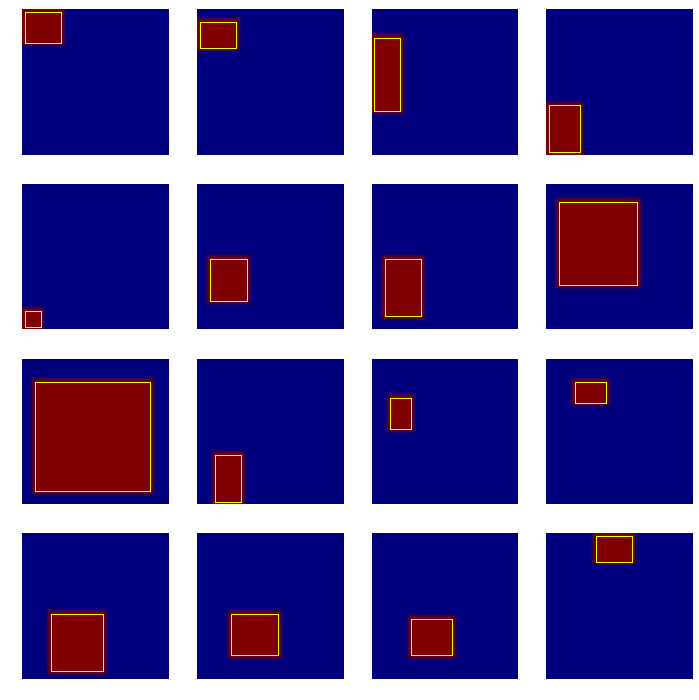

image 1


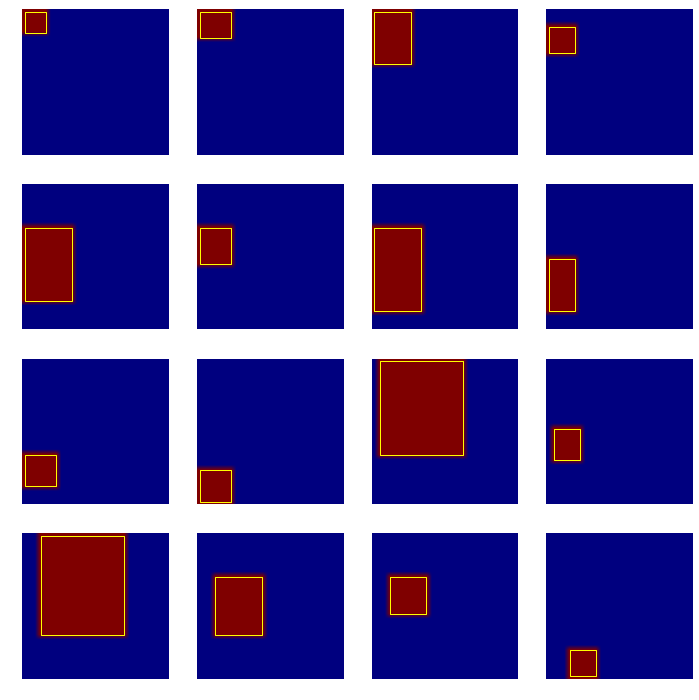

image 2


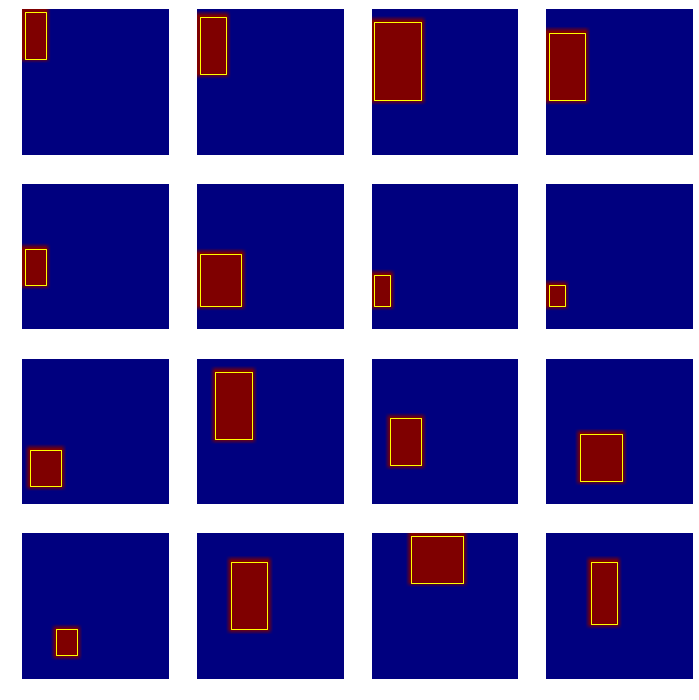

image 3


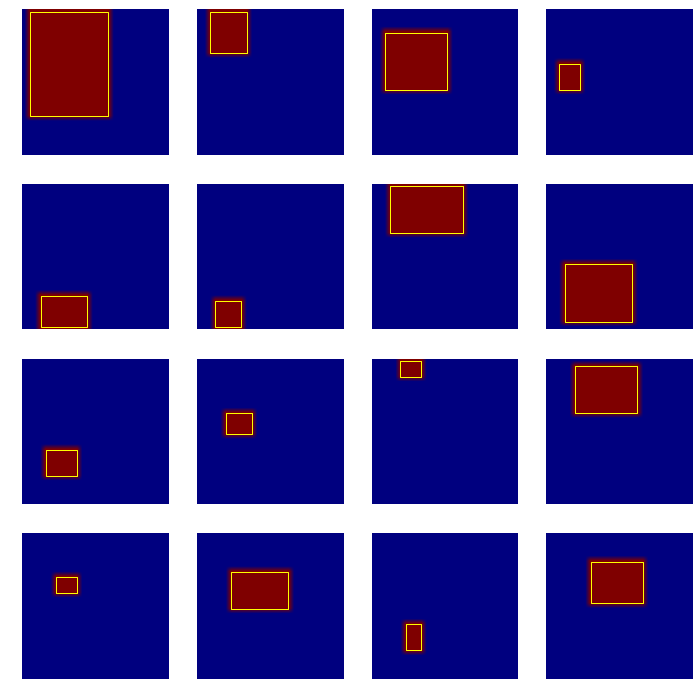

image 4


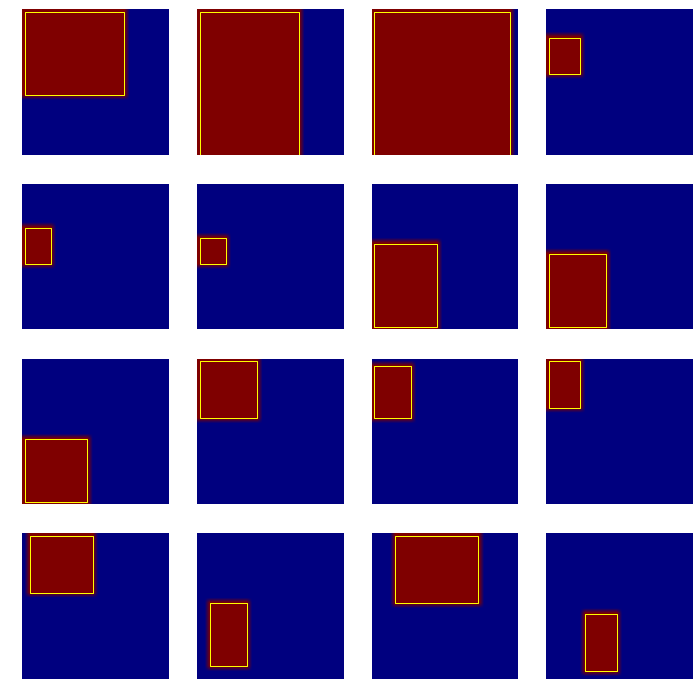

image 5


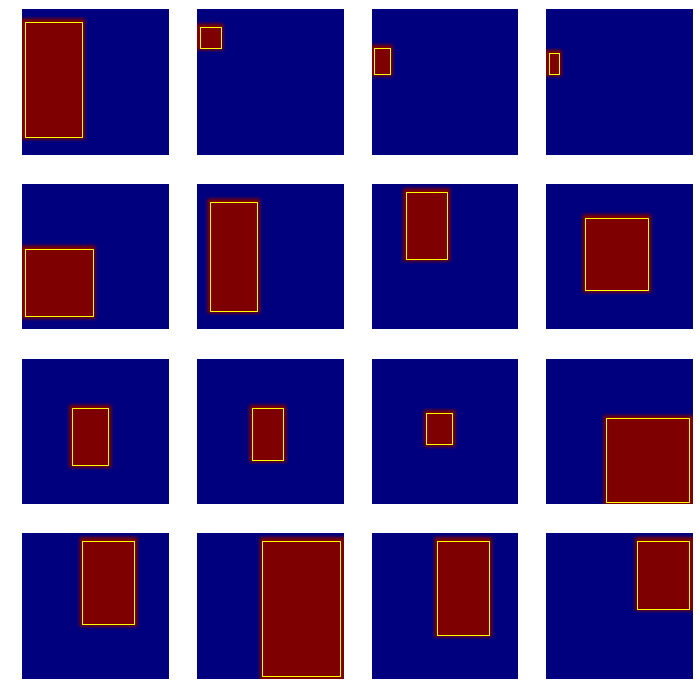

image 6


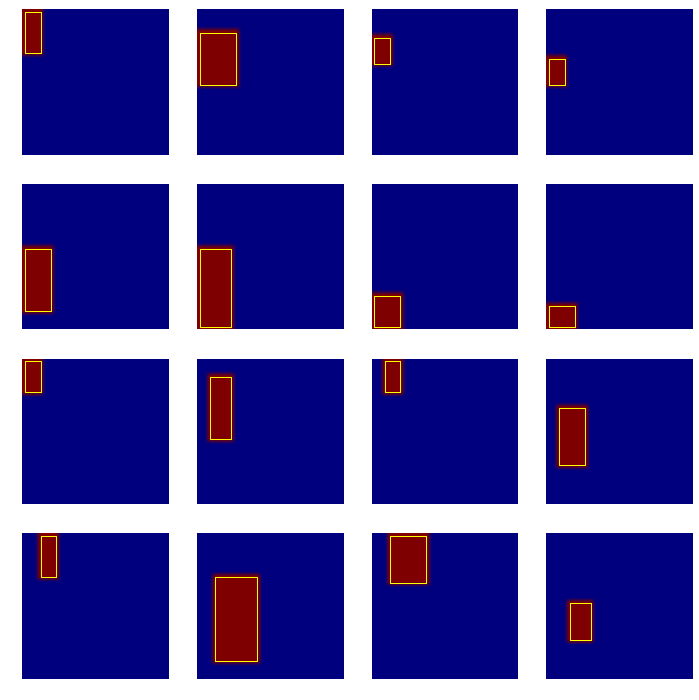

image 7


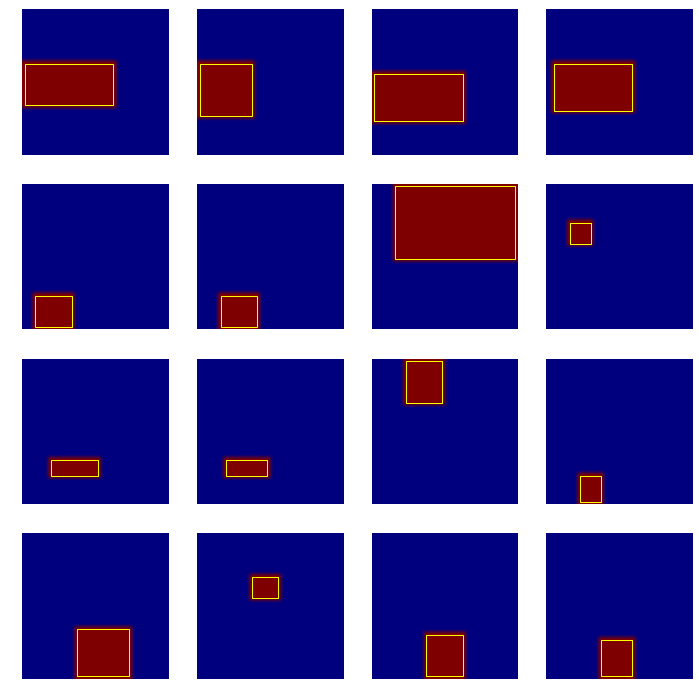

In [163]:
for j in range(batch_size):
    fig = plt.figure(figsize=(12,12))
    for i in range(16):
        rect = B[j,i,:]
        ax = fig.add_subplot(4,4,i+1)
        plt.imshow(A[i,j,:,:])
        ax.add_patch(patches.Rectangle((rect[0],rect[1]),
                                       rect[2],rect[3],
                                       fill=False,color="yellow"))
        plt.axis('off')
    print("image %d" % j)
    plt.show()

In [ ]:
for j in range(batch_size):
    fig = plt.figure(figsize=(12,12))
    for i in range(16):
        ax = fig.add_subplot(4,4,i+1)
        plt.imshow(images[j])
        box = boxes[j,i]
        ax.add_patch(patches.Rectangle((box[0],box[1]),
                                       box[2],box[3],fill=False,color='yellow'))
        plt.axis('off')
    plt.show()

8:
Feeddict = 0.637s (0.080s/image)
Forward = 0.494s (0.062s/image)
16: 
Feeddict = 1.419s (0.089s/image)
Forward = 1.135s (0.071s/image)
20:
Feeddict = 1.638s (0.082s/image)
Forward = 1.854s (0.093s/image)

8:
Feeddict = 0.830s (0.104s/image)
Forward = 1.710s (0.214s/image)
16:
Feeddict = 1.397s (0.087s/image)
Forward = 3.318s (0.207s/image)
20:
Feeddict = 1.617s (0.081s/image)
Forward = 2.684s (0.134s/image)